In [1]:
import sys
sys.path.append("../codes/")

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import math

In [7]:
import utils
import clean

In [8]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Data

In [9]:
df = clean.readClean(file_name="train.csv")
df_ = df.copy(deep=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,cnt
datetime,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [10]:
df.shape

(10886, 9)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  category
 2   workingday  10886 non-null  category
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   cnt         10886 non-null  int64   
dtypes: category(4), float64(3), int64(2)
memory usage: 553.4 KB


In [12]:
print(df.index.min(), " - ", df.index.max())

2011-01-01 00:00:00  -  2012-12-19 23:00:00


In [48]:
house_sessions = pd.read_csv("../data/hosue_sessions_1112.csv")
house_sessions

,date
0,1/3/2012
1,1/6/2012
2,1/10/2012
3,1/13/2012
4,1/17/2012
...,...
320,12/20/2011
321,12/21/2011
322,12/23/2011
323,12/27/2011


## Data Dictionary

In [9]:
pd.read_csv("../data/data_dictionary.csv")

,Name,Def
0,datetime,hourly date + timestamp
1,season,"1 = spring, 2 = summer, 3 = fall, 4 = winter"
2,holiday,whether the day is considered a holiday
3,workingday,whether the day is neither a weekend nor holiday
4,weather,"1: Clear, Few clouds, Partly cloudy, Partly cl..."
5,temp,temperature in Celsius
6,atemp,"""feels like"" temperature in Celsius"
7,humidity,relative humidity
8,windspeed,wind speed
9,casual,number of non-registered user rentals initiated


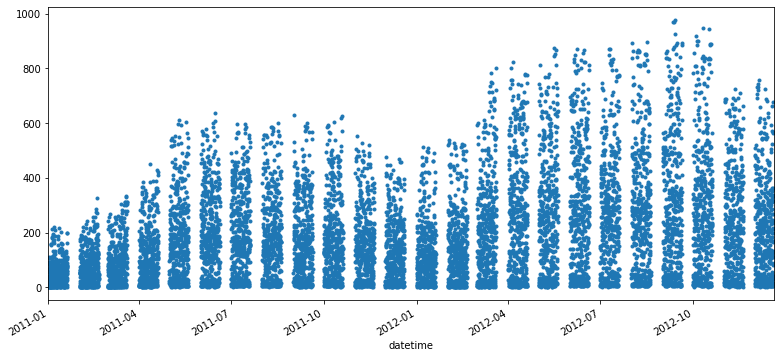

In [10]:
df.cnt.plot(style='.', figsize=(13, 6));

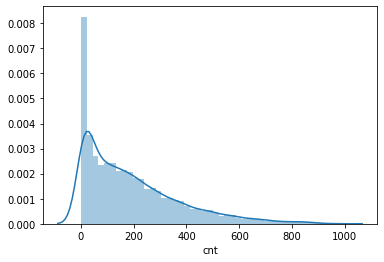

In [11]:
sns.distplot(df.cnt);

In [12]:
df.isnull().sum(axis=0)

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
cnt           0
dtype: int64

**TODOs:**
- Watch for data leakage in `casual` and `registered`.

## Chronicle Gap Pattern

In [13]:
df.asfreq(freq='H').isnull().sum(axis=0)

season        6370
holiday       6370
workingday    6370
weather       6370
temp          6370
atemp         6370
humidity      6370
windspeed     6370
cnt           6370
dtype: int64

In [14]:
dfh = df.asfreq(freq='H')
dfh_missing = dfh[dfh.isnull().sum(axis=1)>0].index

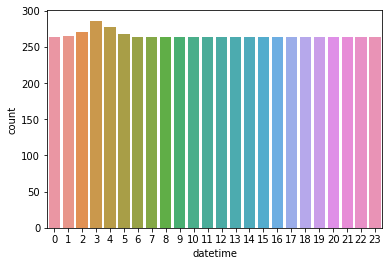

In [15]:
sns.countplot(dfh_missing.hour);

**This looks interesting, data is missing near the end of the month.**

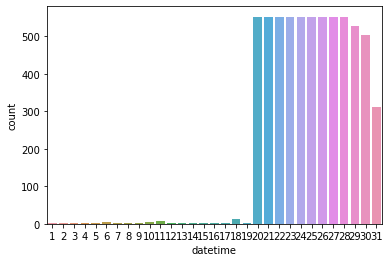

In [16]:
sns.countplot(dfh_missing.day);

In [17]:
(df.index.day >= 20).sum()

0

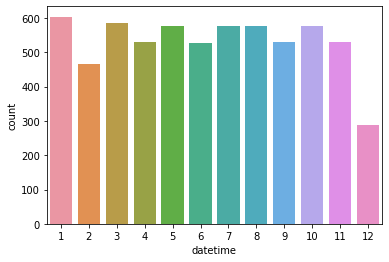

In [18]:
sns.countplot(dfh_missing.month);

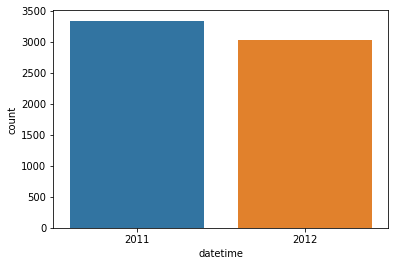

In [19]:
sns.countplot(dfh_missing.year);

Test data

In [20]:
test_df = clean.readClean('test.csv')
print(test_df.index.min(), " - ", test_df.index.max())

2011-01-20 00:00:00  -  2012-12-31 23:00:00


In [21]:
test_df.index.day.unique()

Int64Index([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], dtype='int64', name='datetime')

## ACF and PACF

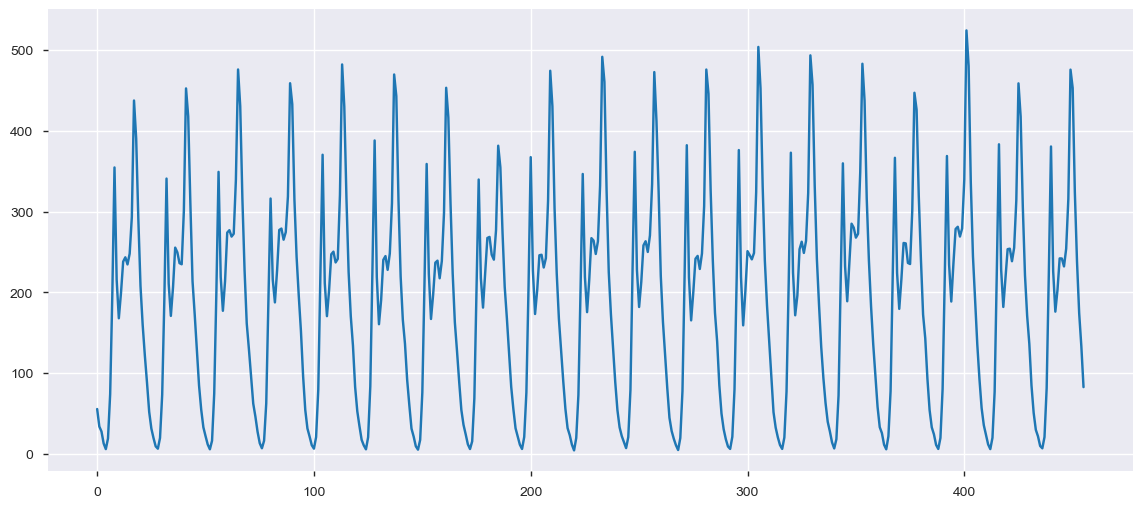

In [42]:
cnt_dh = df.groupby([df.index.day, df.index.hour]).cnt.agg(np.mean)

plt.figure(figsize=(14, 6))
plt.plot(cnt_dh.values);

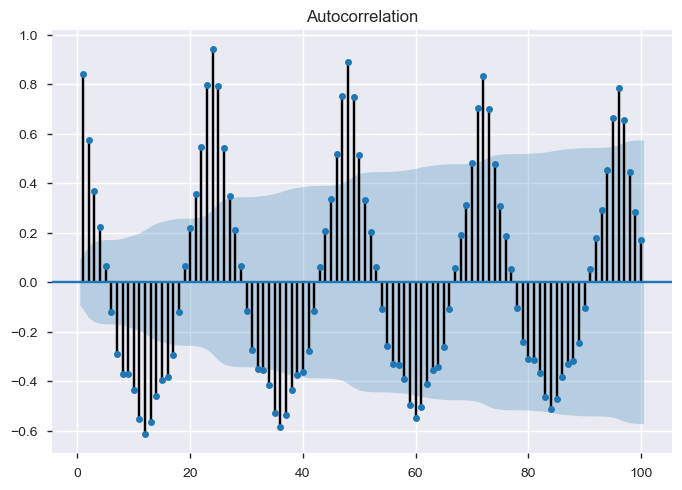

In [109]:
sm.graphics.tsa.plot_acf(cnt_dh, zero=False, lags=100);

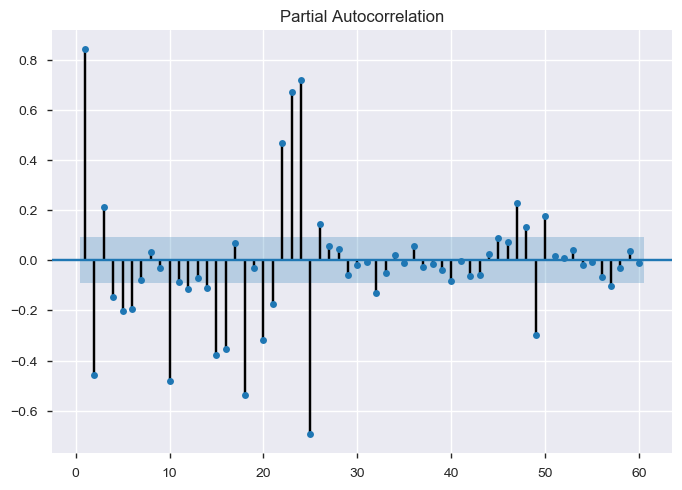

In [53]:
sm.graphics.tsa.plot_pacf(cnt_dh, lags=60, zero=False, method='ols');

- Exponential smoothing
- Prophet

# EDA

**TODO**
- Academic season
- Congress session
- Flights price NY to DC

## Categorical

In [22]:
df['hour'] = (df.index.hour).astype('category')
df['day_of_week'] = (df.index.dayofweek).astype('category')
df['month_of_year'] = (df.index.month).astype('category')

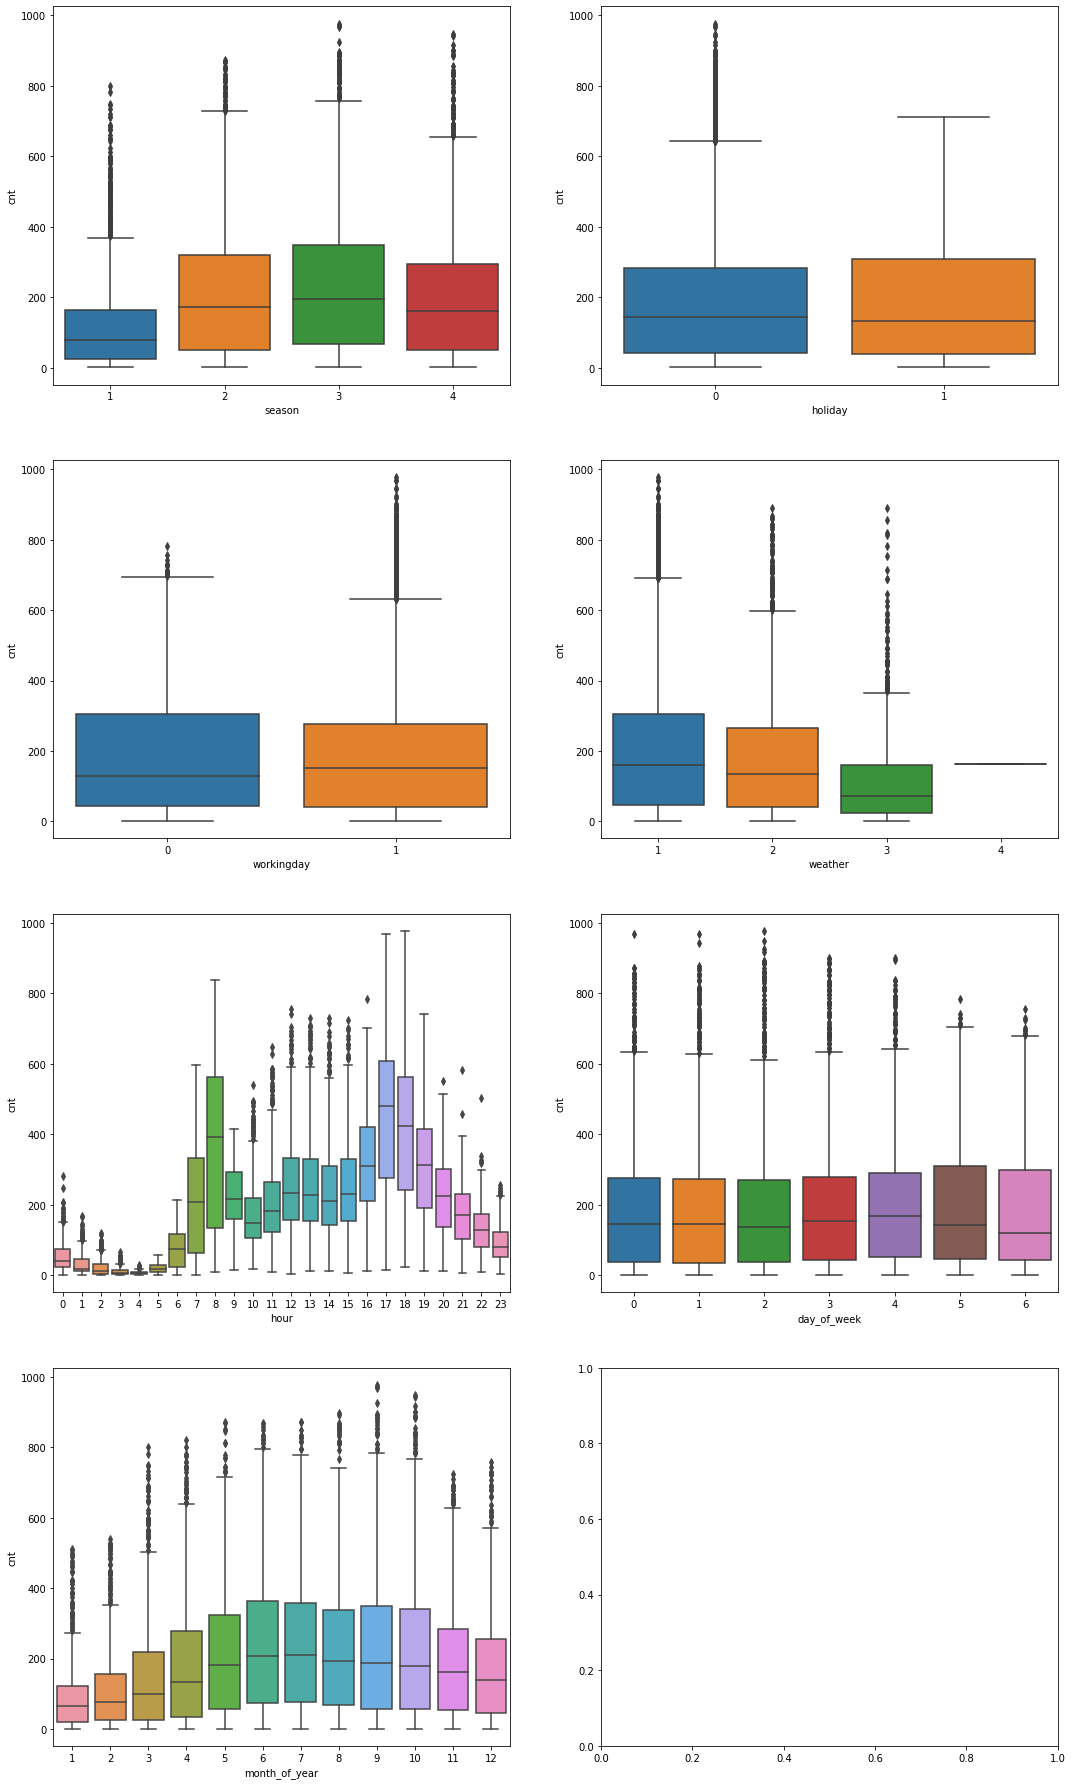

In [23]:
n_cats = (df.dtypes == 'category').sum()
nrows = math.ceil(n_cats / 2) 

fig, axes = plt.subplots(ncols=2, nrows=nrows, figsize=(18, 8*nrows))
for i, col in enumerate(df.columns[df.dtypes == 'category']):
    sns.boxplot(col, 'cnt', data=df, ax=axes[i//2, i%2])

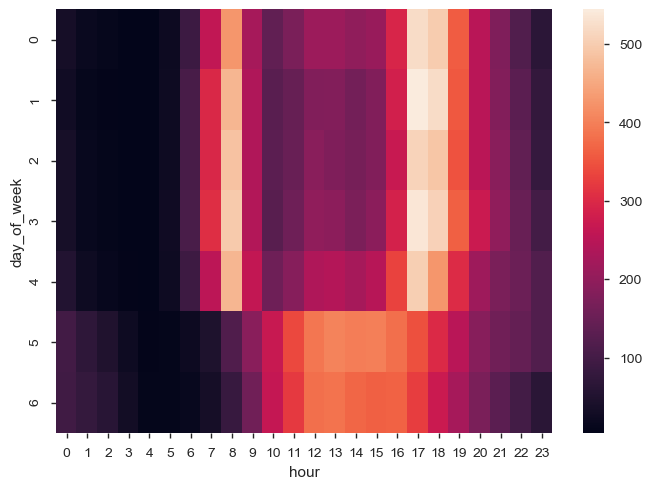

In [78]:
by_dwh = df.groupby(['day_of_week', 'hour']).cnt.agg(np.mean)
by_dwh = by_dwh.reset_index().pivot(columns='hour',index='day_of_week',values='cnt')
sns.heatmap(by_dwh)

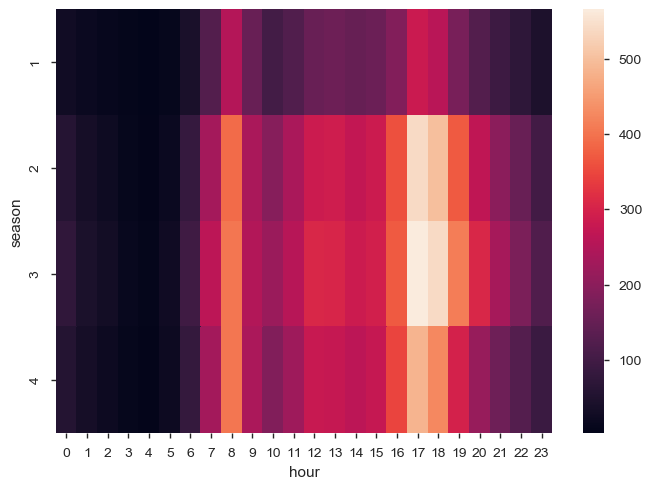

In [81]:
by_mh = df.groupby(['season', 'hour']).cnt.agg(np.mean)
by_mh = by_mh.reset_index().pivot(columns='hour',index='season',values='cnt')
sns.heatmap(by_mh)

## Numerical

In [62]:
df['temp_diff'] = df.atemp - df.temp

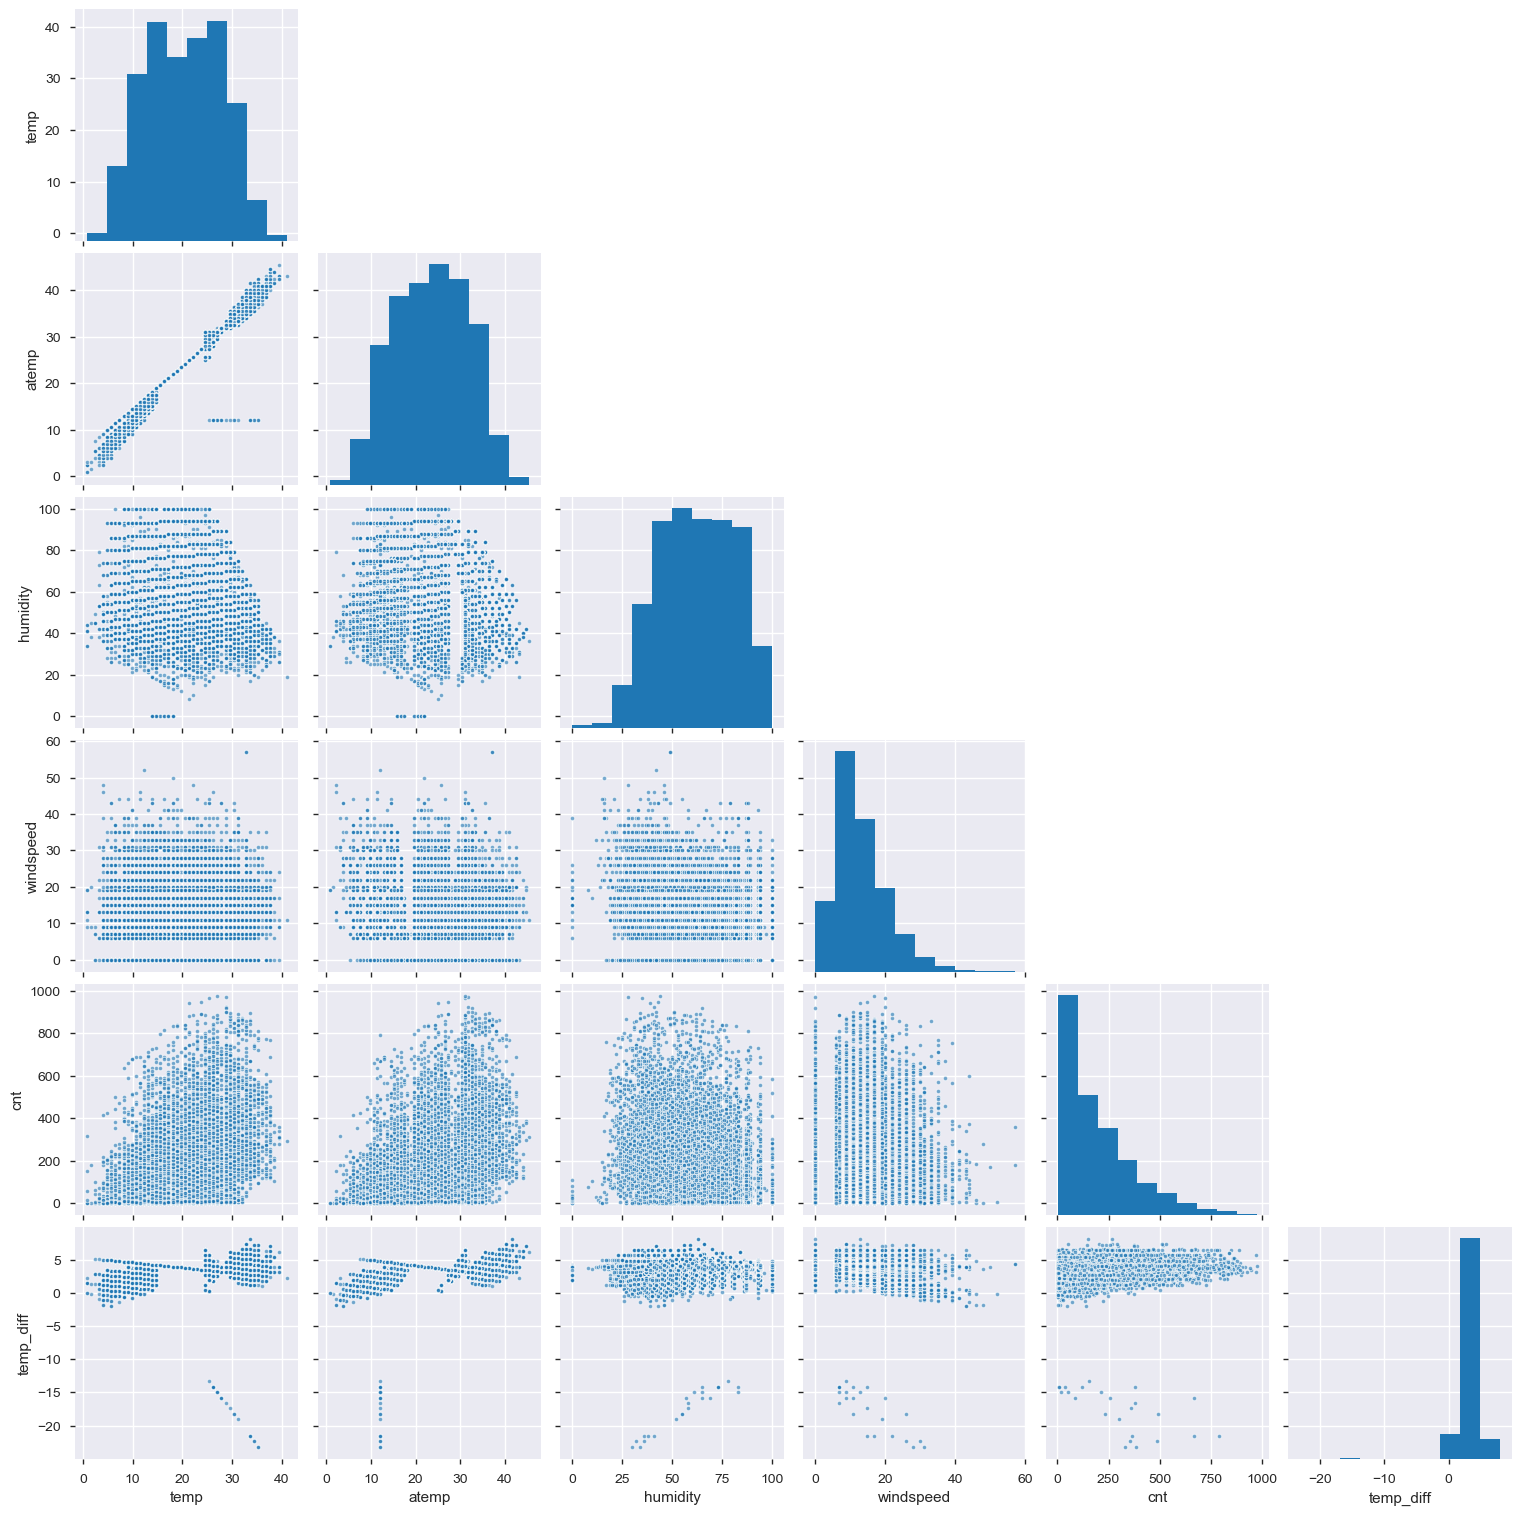

In [68]:
numerical = df.columns[df.dtypes != 'category']
g = sns.pairplot(df[numerical], plot_kws={"s": 10, 'alpha': 0.6})
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

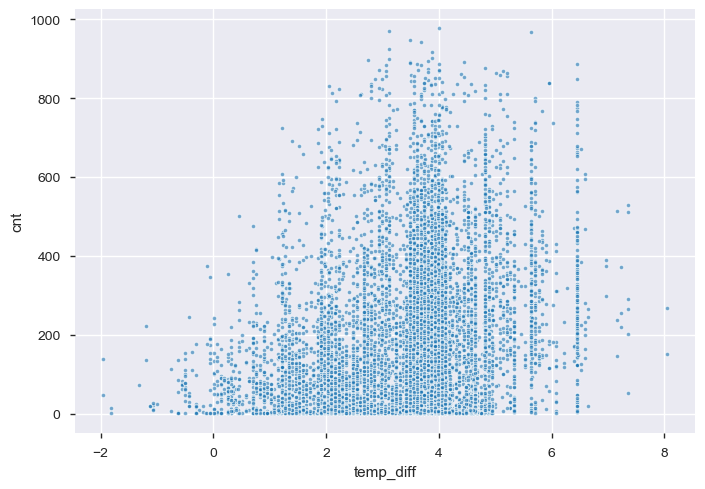

In [69]:
sns.scatterplot('temp_diff', 'cnt', data=df[df.temp_diff > -5],
                s=10, alpha=0.6)

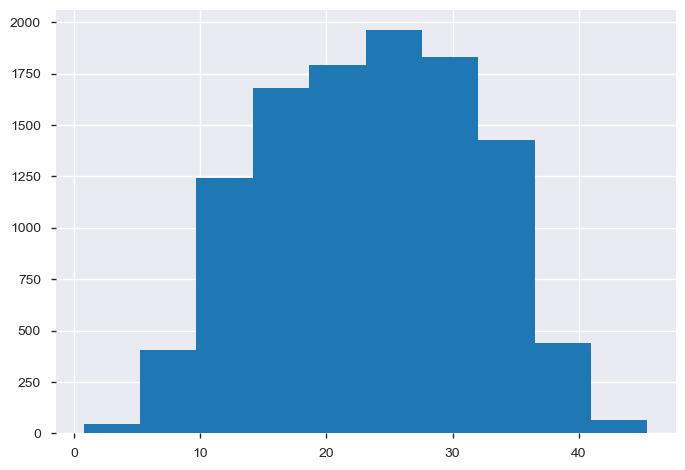

In [91]:
df.atemp.hist()

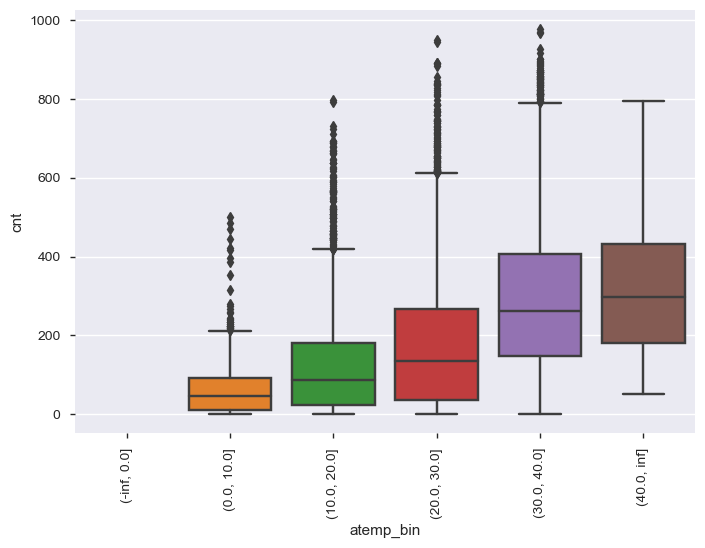

In [102]:
atemp_bins = [-np.Inf] + list(np.arange(0, 50, 10)) + [np.Inf]
df['atemp_bin'] = pd.cut(df.atemp, bins=atemp_bins)
sns.boxplot('atemp_bin', 'cnt', data=df)
plt.xticks(rotation=90);

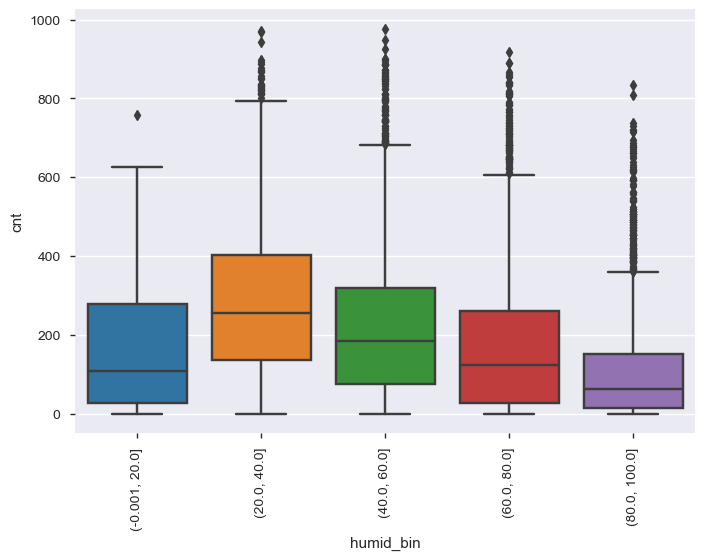

In [105]:
humid_bins = np.arange(0, 110, 20)
df['humid_bin'] = pd.cut(df.humidity, bins=humid_bins, include_lowest=True)
sns.boxplot('humid_bin', 'cnt', data=df)
plt.xticks(rotation=90);

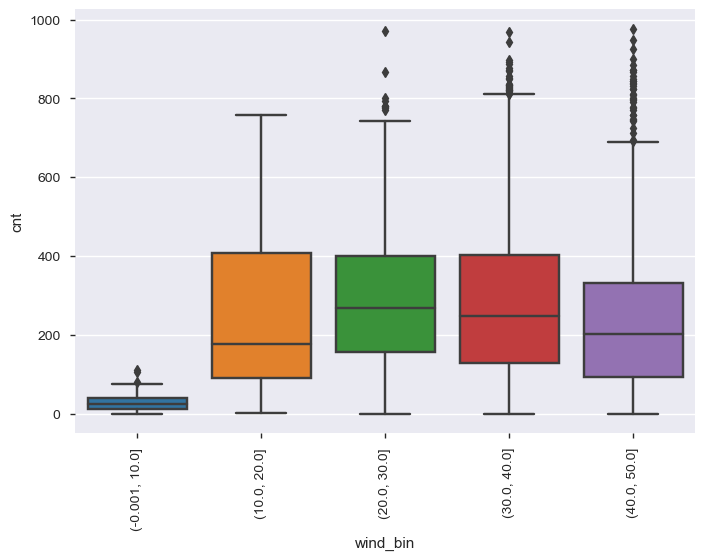

In [108]:
wind_bins = np.arange(0, 60, 10)
df['wind_bin'] = pd.cut(df.humidity, bins=wind_bins, include_lowest=True)
sns.boxplot('wind_bin', 'cnt', data=df)
plt.xticks(rotation=90);